In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from collections import deque

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
warnings.filterwarnings('ignore', category=FutureWarning, module='yfinance')
warnings.filterwarnings('ignore', category=DeprecationWarning)

print("Libraries imported successfully.")

# Define the directory where models are saved
model_dir = 'trained_models'
lgbm_model_path = os.path.join(model_dir, 'lgbm_trading_model.pkl')
scaler_path = os.path.join(model_dir, 'scaler.pkl')

# Load the trained LightGBM model and scaler
lgbm_model = None
scaler = None
try:
    with open(lgbm_model_path, 'rb') as f:
        lgbm_model = pickle.load(f)
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    print("LightGBM model and scaler loaded successfully.")
except FileNotFoundError:
    print("ERROR: Trained LightGBM model or scaler not found. Please run 'ML_Model_Implementation.ipynb' first.")
    print("Cannot proceed with simulation as models are required.")
    # Set a flag to prevent simulation from running
    models_loaded_successfully = False
else:
    models_loaded_successfully = True


# Define the features that our model expects
# This list must match the features used during training
FEATURES = [
    'macd', 'macd_signal', 'rolling_std_20', 'rsi', 'signed_volume',
    'log_return_lag_1', 'rsi_lag_1', 'log_return_lag_2', 'rsi_lag_2',
    'log_return_lag_3', 'rsi_lag_3', 'log_return_lag_5', 'rsi_lag_5',
    'log_return_lag_10', 'rsi_lag_10', 'hour', 'minute'
]

Libraries imported successfully.
LightGBM model and scaler loaded successfully.


### Real-time Data Feed Mock

In [70]:
print("\n Setting up Mock Real-time Data Feed")

def mock_realtime_data_feed(ticker="NVDA", period="7d", interval="1m"):
    print(f"Fetching historical data for {ticker} to simulate real-time feed...")
    df_hist = yf.Ticker(ticker).history(period=period, interval=interval)
    df_hist.dropna(inplace=True)
    print(f"Loaded {len(df_hist)} historical data points for simulation.")

    for index, row in df_hist.iterrows():  
        yield index, row

DATA_BUFFER_SIZE = 100
data_buffer = deque(maxlen=DATA_BUFFER_SIZE)

print(f"Data buffer initialized with max size: {DATA_BUFFER_SIZE}")


 Setting up Mock Real-time Data Feed
Data buffer initialized with max size: 100


### Real-time Feature Computation

In [73]:
print("\n Defining Real-time Feature Computation Logic")

def compute_realtime_features(new_data_point_row, data_buffer_deque):
    # Appending the new data point to the buffer
    data_buffer_deque.append(new_data_point_row)

    temp_df = pd.DataFrame(list(data_buffer_deque))
    temp_df.index = pd.to_datetime(temp_df.index) # Ensure index is DatetimeIndex

    # Ensure essential columns exist (Open, High, Low, Close, Volume)
    required_ohlcv = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in required_ohlcv:
        if col not in temp_df.columns:
            temp_df[col] = np.nan # Placeholder if not present

    # Feature Engineering (replicated from previous notebook, applied to temp_df)
    
    # Log Returns
    temp_df['log_return'] = np.log(temp_df['Close'] / temp_df['Close'].shift(1))

    # Momentum Features (MACD)
    temp_df['ema_12'] = temp_df['Close'].ewm(span=12, adjust=False).mean()
    temp_df['ema_26'] = temp_df['Close'].ewm(span=26, adjust=False).mean()
    temp_df['macd'] = temp_df['ema_12'] - temp_df['ema_26']
    temp_df['macd_signal'] = temp_df['macd'].ewm(span=9, adjust=False).mean()

    # Volatility features (Bollinger Bands components)
    temp_df['rolling_std_20'] = temp_df['Close'].rolling(window=20).std()
    temp_df['bollinger_high'] = temp_df['Close'].rolling(window=20).mean() + (temp_df['rolling_std_20'] * 2)
    temp_df['bollinger_low'] = temp_df['Close'].rolling(window=20).mean() - (temp_df['rolling_std_20'] * 2)

    # Oscillator features (RSI)
    delta = temp_df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    with np.errstate(divide='ignore', invalid='ignore'):
        rs = gain / loss
        temp_df['rsi'] = 100 - (100 / (1 + rs))
    temp_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Order flow proxy
    temp_df['signed_volume'] = temp_df['Volume'] * np.sign(temp_df['log_return'])

    # Lagged features
    for i in [1, 2, 3, 5, 10]:
        temp_df[f'log_return_lag_{i}'] = temp_df['log_return'].shift(i)
        temp_df[f'rsi_lag_{i}'] = temp_df['rsi'].shift(i)

    # Time-based feature ensuring index is datetime before extracting hour/minute
    if not isinstance(temp_df.index, pd.DatetimeIndex):
        temp_df.index = pd.to_datetime(temp_df.index)
    temp_df['hour'] = temp_df.index.hour
    temp_df['minute'] = temp_df.index.minute

    # Geting the latest computed features. Using .tail(1) to get the last row as a DataFrame
    latest_features_df = temp_df[FEATURES].tail(1)

    if latest_features_df.isnull().values.any():
        # print("Warning: Latest features contain NaN values. Skipping prediction for this step.")
        return None

    return latest_features_df


 Defining Real-time Feature Computation Logic


### ML Model Inference

In [76]:
print("\n Defining ML Model Inference Logic")

def get_ml_prediction(features_df, model, scaler):
    # Ensuring features_df has the correct columns and is in the right format for scaling
    if features_df is None or features_df.empty:
        return None, None # No features to predict

    # Scaling the single data point using the *fitted* scaler
    # reshaping(-1, 1) if it's a single feature, but here it's a row of multiple features
    scaled_features = scaler.transform(features_df)
    
    # Predict using the model
    prediction = model.predict(scaled_features)[0]
    prediction_proba = model.predict_proba(scaled_features)[0, 1]

    return prediction, prediction_proba


 Defining ML Model Inference Logic


### Strategy Execution Logic

In [79]:
print("\n Defining Strategy Execution Logic")

def execute_trading_strategy(prediction, prediction_proba, current_price, current_portfolio):
    action = "HOLD"
    order_size = 0
    trade_info = {}

    # Example threshold for action based on probability
    BUY_THRESHOLD = 0.55 
    SELL_THRESHOLD = 0.45 
    
    if prediction == 1 and prediction_proba > BUY_THRESHOLD:
        action = "BUY"
        
        if current_portfolio['cash'] >= current_price * 10: # Example: buy 10 shares
            order_size = 10
            # Simulate order placement (in a real system, this calls a brokerage API)
            trade_info = {'type': action, 'qty': order_size, 'price': current_price}
            print(f"  ACTION: {action} {order_size} shares at ${current_price:.2f} (Prob: {prediction_proba:.2f})")
        else:
            action = "HOLD"
            print(f"  ACTION: HOLD (Insufficient cash to buy 10 shares)")

    elif prediction == 0 and prediction_proba < SELL_THRESHOLD:
        action = "SELL"
        # Simple position sizing: sell all held shares
        if current_portfolio['shares_held'] > 0:
            order_size = current_portfolio['shares_held']
            trade_info = {'type': action, 'qty': order_size, 'price': current_price}
            print(f"  ACTION: {action} {order_size} shares at ${current_price:.2f} (Prob: {prediction_proba:.2f})")
        else:
            action = "HOLD"
            print(f"  ACTION: HOLD (No shares to sell)")
    else:
        print(f"  ACTION: HOLD (Prediction: {prediction}, Prob: {prediction_proba:.2f} - within neutral zone)")

    return action, order_size, trade_info


 Defining Strategy Execution Logic


### Performance Monitoring Setup

In [90]:
print("\n Setting up Performance Monitoring")

# Initialize portfolio state
portfolio = {
    'cash': 100000.0,
    'shares_held': 0,
    'net_worth_history': [100000.0],
    'trade_history': []
}

def update_portfolio(portfolio_state, action, order_size, current_price, trade_info):
    
    if action == "BUY" and order_size > 0:
        cost = order_size * current_price
        portfolio_state['cash'] -= cost
        portfolio_state['shares_held'] += order_size
        portfolio_state['trade_history'].append({'time': pd.Timestamp.now(), 'action': 'BUY', 'qty': order_size, 'price': current_price, 'info': trade_info})
    elif action == "SELL" and order_size > 0:
        revenue = order_size * current_price
        portfolio_state['cash'] += revenue
        portfolio_state['shares_held'] -= order_size # Update shares_held after selling
        portfolio_state['trade_history'].append({'time': pd.Timestamp.now(), 'action': 'SELL', 'qty': order_size, 'price': current_price, 'info': trade_info})
    
    # Calculate current net worth
    current_net_worth = portfolio_state['cash'] + (portfolio_state['shares_held'] * current_price)
    portfolio_state['net_worth_history'].append(current_net_worth)
    
    return portfolio_state


 Setting up Performance Monitoring


### Model Monitoring and Retraining

In [93]:
print("\n Conceptualizing Model Monitoring and Retraining")


 Conceptualizing Model Monitoring and Retraining


### End-to-End System Simulation (Illustrative Loop)


 Running End-to-End System Simulation (Illustrative)
Starting real-time simulation. Processing 1-minute bars...
Filling initial data buffer (100 points required)...
Buffer filled with 100 initial data points.
Fetching historical data for NVDA to simulate real-time feed...
Loaded 2412 historical data points for simulation.

 Processing new data point: 2025-07-23 11:12:00-04:00 (Step 1)
  Current Price: $169.40
  Features computed for 2025-07-23 11:12:00-04:00: {'macd': 0.12915013788162355, 'macd_signal': 0.14856067923649421, 'rolling_std_20': 0.1728921282378673, 'rsi': 53.81273756884648, 'signed_volume': -235901.0, 'log_return_lag_1': 0.00012449140708072168, 'rsi_lag_1': 60.290313308421965, 'log_return_lag_2': 7.309979033883088e-05, 'rsi_lag_2': 60.06071118820468, 'log_return_lag_3': -0.0005013283957131069, 'rsi_lag_3': 64.07349135969417, 'log_return_lag_5': -3.8909927575650725e-05, 'rsi_lag_5': 68.728736674983, 'log_return_lag_10': 0.00011026907283877587, 'rsi_lag_10': 88.234990915299

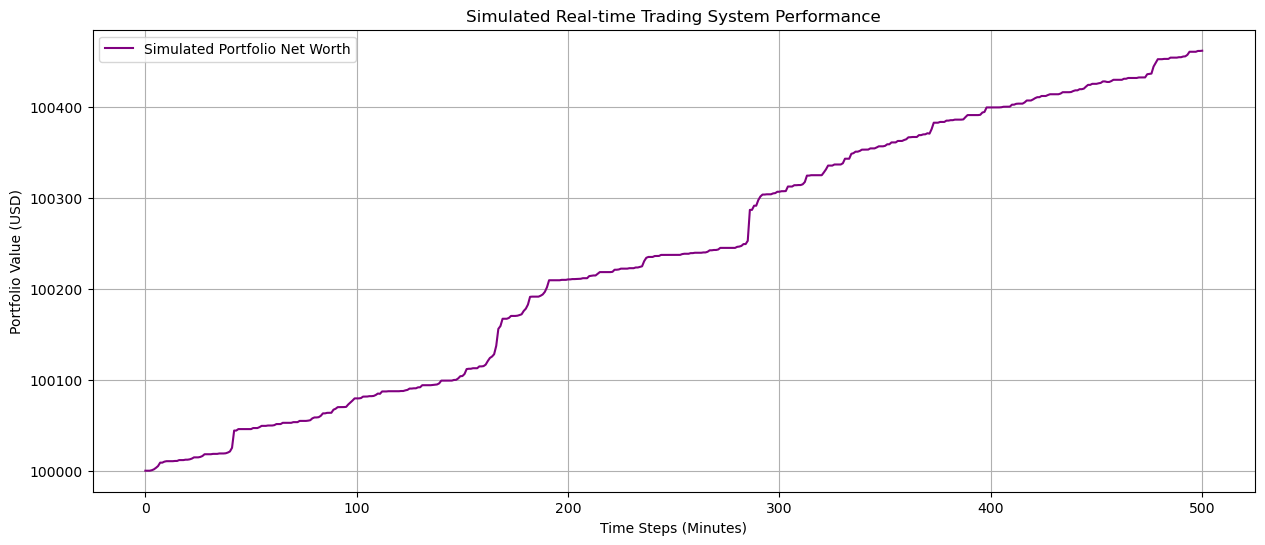

In [96]:
print("\n Running End-to-End System Simulation (Illustrative)")
print("Starting real-time simulation. Processing 1-minute bars...")

# Checking if models were loaded successfully before proceeding with simulation
if not models_loaded_successfully:
    print("Cannot run simulation: Models were not loaded successfully. Please ensure 'ML_Model_Implementation.ipynb' was run and saved models.")
else:
    # Reset portfolio for simulation
    portfolio = {
        'cash': 100000.0,
        'shares_held': 0,
        'net_worth_history': [100000.0],
        'trade_history': []
    }

    SIMULATION_STEPS = 500 # Process 500 minutes of data
    processed_steps = 0

    # Use the mock data feed
    data_generator = mock_realtime_data_feed(ticker="NVDA", period="7d", interval="1m")

    # Fill initial data buffer for feature calculation
    print(f"Filling initial data buffer ({DATA_BUFFER_SIZE} points required)...")
    # Fetch enough data to potentially fill the buffer and then start the real-time loop
    initial_df_for_buffer = yf.Ticker("NVDA").history(period="7d", interval="1m")
    initial_df_for_buffer.dropna(inplace=True)

    # Ensuring enough data availablity to fill the buffer
    if len(initial_df_for_buffer) < DATA_BUFFER_SIZE:
        print(f"WARNING: Not enough historical data ({len(initial_df_for_buffer)} points) to fully fill buffer ({DATA_BUFFER_SIZE} points). Features might be NaN initially.")
        initial_fill_count = len(initial_df_for_buffer)
    else:
        initial_fill_count = DATA_BUFFER_SIZE

    for i in range(initial_fill_count): # Fill the buffer
        data_buffer.append(initial_df_for_buffer.iloc[i])
    print(f"Buffer filled with {len(data_buffer)} initial data points.")

    data_generator = mock_realtime_data_feed(ticker="NVDA", period="7d", interval="1m")
    # Skipping the data points already used to fill the buffer
    for _ in range(initial_fill_count):
        try:
            next(data_generator)
        except StopIteration:
            print("Warning: Data generator exhausted while skipping initial buffer points.")
            break # Break if no more data

    for timestamp, new_row in data_generator:
        if processed_steps >= SIMULATION_STEPS:
            break # Stop simulation after desired steps

        print(f"\n Processing new data point: {timestamp} (Step {processed_steps + 1})")
        current_price = new_row['Close']
        print(f"  Current Price: ${current_price:.2f}")

        latest_features_df = compute_realtime_features(new_row.copy(), data_buffer)

        if latest_features_df is None:
            print("  Skipping prediction: Features could not be computed (e.g., NaNs or insufficient data).")
            portfolio = update_portfolio(portfolio, "HOLD", 0, current_price, {})
            processed_steps += 1
            continue

        # Converting latest_features_df to a dictionary for printing to avoid DataFrame formatting issues
        features_dict_for_print = latest_features_df.iloc[0].to_dict()
        print(f"  Features computed for {timestamp}: {features_dict_for_print}")

        # 2. ML Model Inference
        prediction, prediction_proba = get_ml_prediction(latest_features_df, lgbm_model, scaler)

        if prediction is None:
            print("  Skipping strategy: Prediction failed.")
            portfolio = update_portfolio(portfolio, "HOLD", 0, current_price, {})
            processed_steps += 1
            continue

        print(f"  ML Prediction: {prediction} (Probability: {prediction_proba:.2f})")

        # 3. Strategy Execution
        action, order_size, trade_info = execute_trading_strategy(prediction, prediction_proba, current_price, portfolio)

        # 4. Performance Monitoring (Update Portfolio)
        portfolio = update_portfolio(portfolio, action, order_size, current_price, trade_info)
        print(f"  Current Portfolio Value: ${portfolio['net_worth_history'][-1]:.2f} (Cash: ${portfolio['cash']:.2f}, Shares: {portfolio['shares_held']})")

        processed_steps += 1

    print("\n--- Simulation Complete ---")
    print(f"Final Portfolio Value: ${portfolio['net_worth_history'][-1]:.2f}")
    print(f"Total trades executed: {len(portfolio['trade_history'])}")

    # Plot final portfolio value history
    plt.figure(figsize=(15, 6))
    plt.plot(portfolio['net_worth_history'], label='Simulated Portfolio Net Worth', color='purple')
    plt.title('Simulated Real-time Trading System Performance')
    plt.xlabel('Time Steps (Minutes)')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

### System Architecture Overview

In [98]:
print("\n System Architecture Overview (Conceptual)")
print("""
A real-time ML-Powered Trading System typically involves several interconnected components:

1.  **Data Ingestion Layer:**
    -   Connects to exchange APIs (e.g., WebSocket feeds for tick/bar data).
    -   Handles real-time data parsing, validation, and storage (e.g., in-memory data structures, high-performance databases).

2.  **Feature Engineering Service:**
    -   Receives raw data from the ingestion layer.
    -   Computes all required technical indicators and custom features in real-time.
    -   Maintains historical data buffers for rolling calculations.

3.  **Prediction Service (ML Inference Engine):**
    -   Receives real-time features.
    -   Loads pre-trained ML models (e.g., LightGBM, RL agent).
    -   Performs rapid inference to generate trading signals/predictions.
    -   May include ensemble models or multiple models for different market regimes.

4.  **Strategy Engine:**
    -   Receives predictions/signals from the Prediction Service.
    -   Applies complex trading logic (e.g., statistical arbitrage, market-making rules, risk management).
    -   Determines optimal position sizing, stop-loss/take-profit levels.

5.  **Order Execution Management System (OEMS):**
    -   Receives trading decisions from the Strategy Engine.
    -   Connects to brokerage/exchange APIs to place, modify, and cancel orders.
    -   Implements smart order routing (SOR) and execution algorithms (e.g., VWAP, TWAP) to minimize market impact and slippage.

6.  **Risk Management System:**
    -   Monitors overall portfolio exposure, leverage, and PnL in real-time.
    -   Enforces pre-defined risk limits (e.g., max drawdown, max loss per day).
    -   Can automatically halt trading or liquidate positions if limits are breached.

7.  **Performance Monitoring & Alerting:**
    -   Visualizes key performance indicators (KPIs) like PnL, Sharpe Ratio, Drawdown, Win Rate.
    -   Tracks model accuracy and feature drift.
    -   Sends alerts for critical events (e.g., system errors, significant losses, model degradation).

8.  **Model Retraining Pipeline:**
    -   Automated process for periodically retraining models on new data.
    -   Includes data collection, re-feature engineering, training, validation, and deployment.
    -   Ensures models adapt to changing market conditions.

**Interconnections:**
-   Data flows from ingestion -> feature engineering -> prediction -> strategy -> OEMS.
-   Feedback loops from OEMS (execution reports) to Strategy Engine and Risk Management.
-   Monitoring systems pull data from all layers.
-   Retraining pipeline periodically updates Prediction Service models.

This modular design allows for independent development, scaling, and maintenance of each component, crucial for a robust and high-performance trading system.
""")


 System Architecture Overview (Conceptual)

A real-time ML-Powered Trading System typically involves several interconnected components:

1.  **Data Ingestion Layer:**
    -   Connects to exchange APIs (e.g., WebSocket feeds for tick/bar data).
    -   Handles real-time data parsing, validation, and storage (e.g., in-memory data structures, high-performance databases).

2.  **Feature Engineering Service:**
    -   Receives raw data from the ingestion layer.
    -   Computes all required technical indicators and custom features in real-time.
    -   Maintains historical data buffers for rolling calculations.

3.  **Prediction Service (ML Inference Engine):**
    -   Receives real-time features.
    -   Loads pre-trained ML models (e.g., LightGBM, RL agent).
    -   Performs rapid inference to generate trading signals/predictions.
    -   May include ensemble models or multiple models for different market regimes.

4.  **Strategy Engine:**
    -   Receives predictions/signals from the Pr